In [104]:
from xml.etree.ElementInclude import include
import pandas as pd
from typing import Optional, Union
from collections import OrderedDict
import matplotlib.pyplot as plt
from typing import Literal


def parse_nsys_stats_nvtx_csv(
    path: str,
    include_ranges: Optional[list[str]] = None,
    exclude_ranges: Optional[list[str]] = None,
    indices: Optional[OrderedDict[str, Union[int, float, str]]] = None,
    columns: Optional[list[str]] = None,
    sort_key: Optional[list[str]] = None,
) -> pd.DataFrame:
    if (include_ranges is not None) and (exclude_ranges is not None):
        raise ValueError("Either include_ranges or exclude_ranges must be None")

    df_csv = pd.read_csv(path)
    if include_ranges is not None:
        df_csv = df_csv[df_csv["Range"].isin(include_ranges)]
    elif exclude_ranges is not None:
        df_csv = df_csv[~df_csv["Range"].isin(exclude_ranges)]

    if indices is not None:
        for key, value in reversed(list(indices.items())):
            # insert at the beginning
            df_csv.insert(0, key, value)

    if columns is not None:
        columns = list(indices.keys()) + ["Range"] + columns
        df_csv = df_csv[columns]

    if sort_key is not None:
        df_csv["sort_key"] = df_csv["Range"].apply(
            lambda x: sort_key.index(x) if x in sort_key else len(sort_key)
        )
        df_csv = df_csv.sort_values(by="sort_key", ascending=True).drop(
            columns=["sort_key"]
        )

    return df_csv


def parse_nsys_stats_nvtx_gpu_proj_sum_csv(
    path: str,
    include_ranges: Optional[list[str]] = None,
    exclude_ranges: Optional[list[str]] = None,
    indices: Optional[OrderedDict[str, Union[int, float, str]]] = None,
    time_unit: Literal["ns", "us", "ms", "s"] = "ns",
) -> pd.DataFrame:
    df_csv = parse_nsys_stats_nvtx_csv(
        path,
        include_ranges,
        exclude_ranges,
        indices,
        ["Total Proj Time (ns)"],
        sort_key=include_ranges,
    )
    match time_unit:
        case "us":
            df_csv["Total Proj Time (ns)"] = df_csv["Total Proj Time (ns)"] // 1e3
            df_csv.rename(
                columns={"Total Proj Time (ns)": "Total Proj Time (us)"}, inplace=True
            )
        case "ms":
            df_csv["Total Proj Time (ns)"] = df_csv["Total Proj Time (ns)"] // 1e6
            df_csv.rename(
                columns={"Total Proj Time (ns)": "Total Proj Time (ms)"}, inplace=True
            )
        case "s":
            df_csv["Total Proj Time (ns)"] = df_csv["Total Proj Time (ns)"] // 1e9
            df_csv.rename(
                columns={"Total Proj Time (ns)": "Total Proj Time (s)"}, inplace=True
            )
    return df_csv

In [106]:
df_coarse = parse_nsys_stats_nvtx_gpu_proj_sum_csv(
    "./csv/prof-b1_nvtx_gpu_proj_sum.csv",
    include_ranges=["LLM", "Vision adapter"],
    indices={"batch_size": 1},
)
df_fine = parse_nsys_stats_nvtx_gpu_proj_sum_csv(
    "./csv/prof-b1_nvtx_gpu_proj_sum.csv",
    include_ranges=[
        "enc-qkv",
        "enc-attn",
        "enc-proj",
        "enc-ffn",
        "dec-qkv",
        "dec-attn",
        "dec-cross-attn",
        "dec-proj",
        "dec-ffn",
    ],
    indices={"batch_size": 1},
)
df_coarse.Range.unique()
df_fine.Range.unique()

   batch_size           Range  Total Proj Time (ns)
0           1             LLM            2828274529
5           1  Vision adapter             450531908
    batch_size           Range  Total Proj Time (ns)
79           1         enc-qkv              21857640
9            1        enc-attn             284010121
81           1        enc-proj               9329911
15           1         enc-ffn              68269213
7            1         dec-qkv             357901007
10           1        dec-attn             244589807
13           1  dec-cross-attn              93813788
12           1        dec-proj             133598639
2            1         dec-ffn            1368351732


array(['enc-qkv', 'enc-attn', 'enc-proj', 'enc-ffn', 'dec-qkv',
       'dec-attn', 'dec-cross-attn', 'dec-proj', 'dec-ffn'], dtype=object)

In [126]:
# df_coarse, df_fine = parse_nvtx_gpu_proj_csv("./csv/prof-b1_nvtx_gpu_proj_sum.csv")
batch_sizes = [1, 2, 4, 8, 16]  # 여러 batch_size 값을 설정합니다.
df_coarse_list = []
df_fine_list = []

for batch_size in batch_sizes:
    df_coarse = parse_nsys_stats_nvtx_gpu_proj_sum_csv(
        f"./csv/prof-b{batch_size}_nvtx_gpu_proj_sum.csv",
        include_ranges=["Vision adapter", "LLM"],
        indices={"batch_size": batch_size},
        time_unit="ms",
    )
    df_fine = parse_nsys_stats_nvtx_gpu_proj_sum_csv(
        f"./csv/prof-b{batch_size}_nvtx_gpu_proj_sum.csv",
        include_ranges=[
            "enc-qkv",
            "enc-attn",
            "enc-proj",
            "enc-ffn",
            "dec-qkv",
            "dec-attn",
            "dec-cross-attn",
            "dec-proj",
            "dec-ffn",
        ],
        indices={"batch_size": batch_size},
        time_unit="ms",
    )
    df_coarse_list.append(df_coarse)
    df_fine_list.append(df_fine)

df_coarse = pd.concat(df_coarse_list, ignore_index=True)
df_fine = pd.concat(df_fine_list, ignore_index=True)

   batch_size           Range  Total Proj Time (ns)
5           1  Vision adapter             450531908
0           1             LLM            2828274529
    batch_size           Range  Total Proj Time (ns)
79           1         enc-qkv              21857640
9            1        enc-attn             284010121
81           1        enc-proj               9329911
15           1         enc-ffn              68269213
7            1         dec-qkv             357901007
10           1        dec-attn             244589807
13           1  dec-cross-attn              93813788
12           1        dec-proj             133598639
2            1         dec-ffn            1368351732
   batch_size           Range  Total Proj Time (ns)
5           2  Vision adapter             813050527
0           2             LLM            2761812190
    batch_size           Range  Total Proj Time (ns)
62           2         enc-qkv              42035311
8            2        enc-attn             563245927

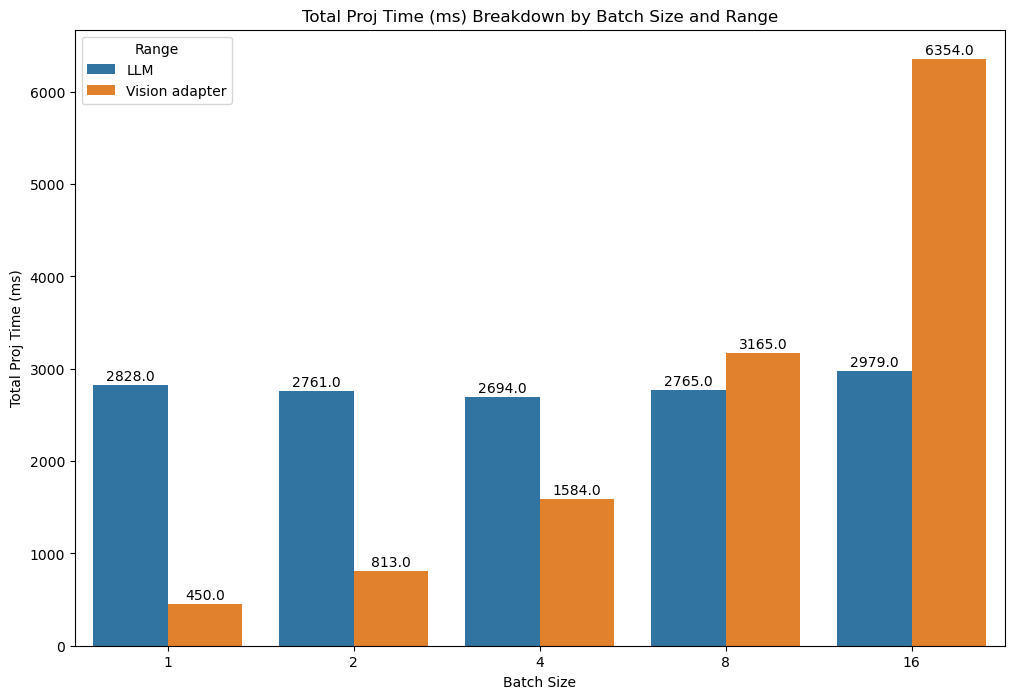

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns


def add_bar_labels(ax, bars, offset, fontsize=10, color="black"):
    """
    막대 그래프에 데이터 레이블을 추가하는 함수

    Parameters:
    - ax: matplotlib axes 객체 (그래프를 그릴 Axes)
    - bars: bar 객체 리스트 (ax.bar()의 반환 값)
    - offset: 막대 위에 레이블을 얼마나 떨어뜨릴지 조정하는 값
    - fontsize: 레이블 폰트 크기
    - color: 레이블 색상
    """
    for bar in bars:
        height = bar.get_height()
        if bar.get_x() + bar.get_width() / 2 == 0.0 and height == 0.0:
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # 막대의 x 위치 (가운데 정렬)
            height + offset,  # 막대의 y 위치 (조금 위)
            f"{height}",  # 레이블 (소수점 2자리)
            ha="center",  # 가로 중앙 정렬
            fontsize=fontsize,
            color=color,
        )


# batch_size별로 Total Proj Time (ns) 컬럼의 값을 breakdown합니다.
plt.figure(figsize=(12, 8))
sns.barplot(x="batch_size", y="Total Proj Time (ms)", hue="Range", data=df_coarse)
plt.title("Total Proj Time (ms) Breakdown by Batch Size and Range")
plt.xlabel("Batch Size")
plt.ylabel("Total Proj Time (ms)")
plt.legend(title="Range")

add_bar_labels(plt.gca(), plt.gca().patches, offset=50)

plt.show()

<Figure size 1200x800 with 0 Axes>

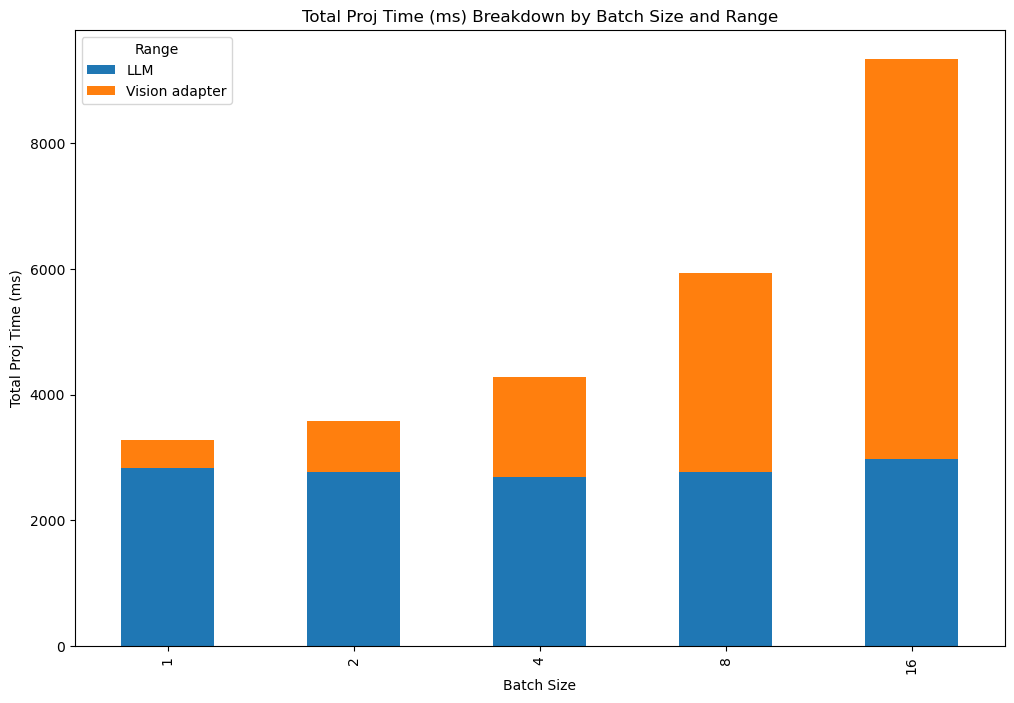

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns


def add_bar_labels(ax, bars, offset, fontsize=10, color="black"):
    """
    막대 그래프에 데이터 레이블을 추가하는 함수

    Parameters:
    - ax: matplotlib axes 객체 (그래프를 그릴 Axes)
    - bars: bar 객체 리스트 (ax.bar()의 반환 값)
    - offset: 막대 위에 레이블을 얼마나 떨어뜨릴지 조정하는 값
    - fontsize: 레이블 폰트 크기
    - color: 레이블 색상
    """
    for bar in bars:
        height = bar.get_height()
        if bar.get_x() + bar.get_width() / 2 == 0.0 and height == 0.0:
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # 막대의 x 위치 (가운데 정렬)
            height + offset,  # 막대의 y 위치 (조금 위)
            f"{height}",  # 레이블 (소수점 2자리)
            ha="center",  # 가로 중앙 정렬
            fontsize=fontsize,
            color=color,
        )


# batch_size별로 Total Proj Time (ns) 컬럼의 값을 breakdown합니다.
plt.figure(figsize=(12, 8))
df_coarse_pivot = df_coarse.pivot_table(
    index="batch_size", columns="Range", values="Total Proj Time (ms)", aggfunc="sum"
)
df_coarse_pivot.plot(kind="bar", stacked=True, figsize=(12, 8))

plt.title("Total Proj Time (ms) Breakdown by Batch Size and Range")
plt.xlabel("Batch Size")
plt.ylabel("Total Proj Time (ms)")
plt.legend(title="Range")

plt.show()

<Figure size 1200x800 with 0 Axes>

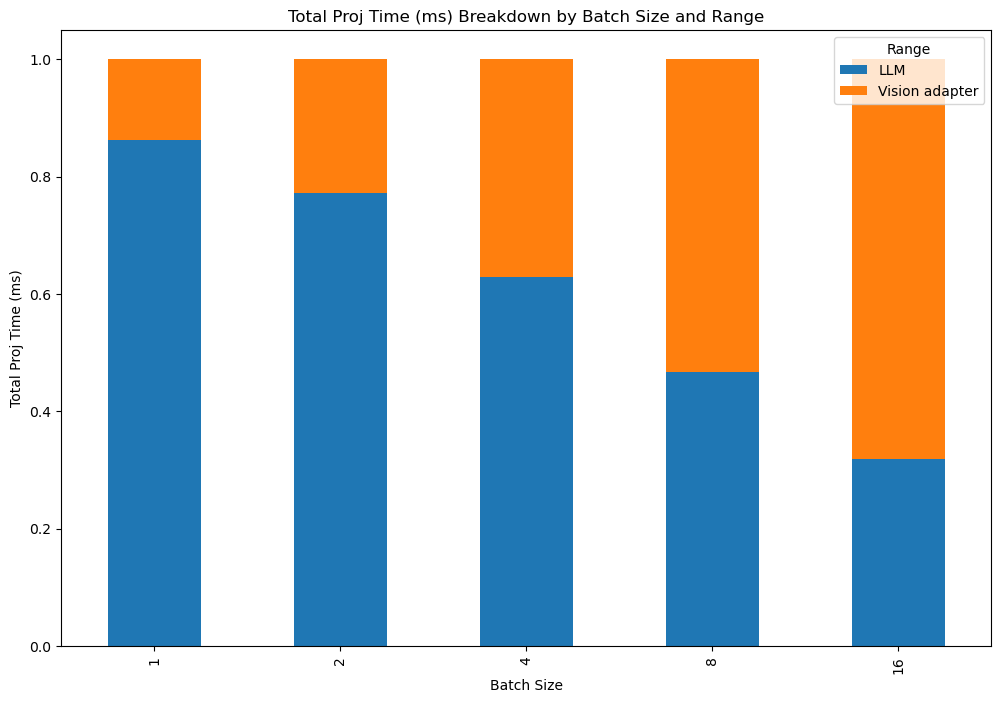

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns


def add_bar_labels(ax, bars, offset, fontsize=10, color="black"):
    """
    막대 그래프에 데이터 레이블을 추가하는 함수

    Parameters:
    - ax: matplotlib axes 객체 (그래프를 그릴 Axes)
    - bars: bar 객체 리스트 (ax.bar()의 반환 값)
    - offset: 막대 위에 레이블을 얼마나 떨어뜨릴지 조정하는 값
    - fontsize: 레이블 폰트 크기
    - color: 레이블 색상
    """
    for bar in bars:
        height = bar.get_height()
        if bar.get_x() + bar.get_width() / 2 == 0.0 and height == 0.0:
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # 막대의 x 위치 (가운데 정렬)
            height + offset,  # 막대의 y 위치 (조금 위)
            f"{height}",  # 레이블 (소수점 2자리)
            ha="center",  # 가로 중앙 정렬
            fontsize=fontsize,
            color=color,
        )


# batch_size별로 Total Proj Time (ns) 컬럼의 값을 breakdown합니다.
plt.figure(figsize=(12, 8))
df_coarse_pivot = df_coarse.pivot_table(
    index="batch_size", columns="Range", values="Total Proj Time (ms)", aggfunc="sum"
)
df_coarse_pivot = df_coarse_pivot.div(df_coarse_pivot.sum(axis=1), axis=0)
df_coarse_pivot.plot(kind="bar", stacked=True, figsize=(12, 8))

plt.title("Total Proj Time (ms) Breakdown by Batch Size and Range")
plt.xlabel("Batch Size")
plt.ylabel("Total Proj Time (ms)")
plt.legend(title="Range")

plt.show()

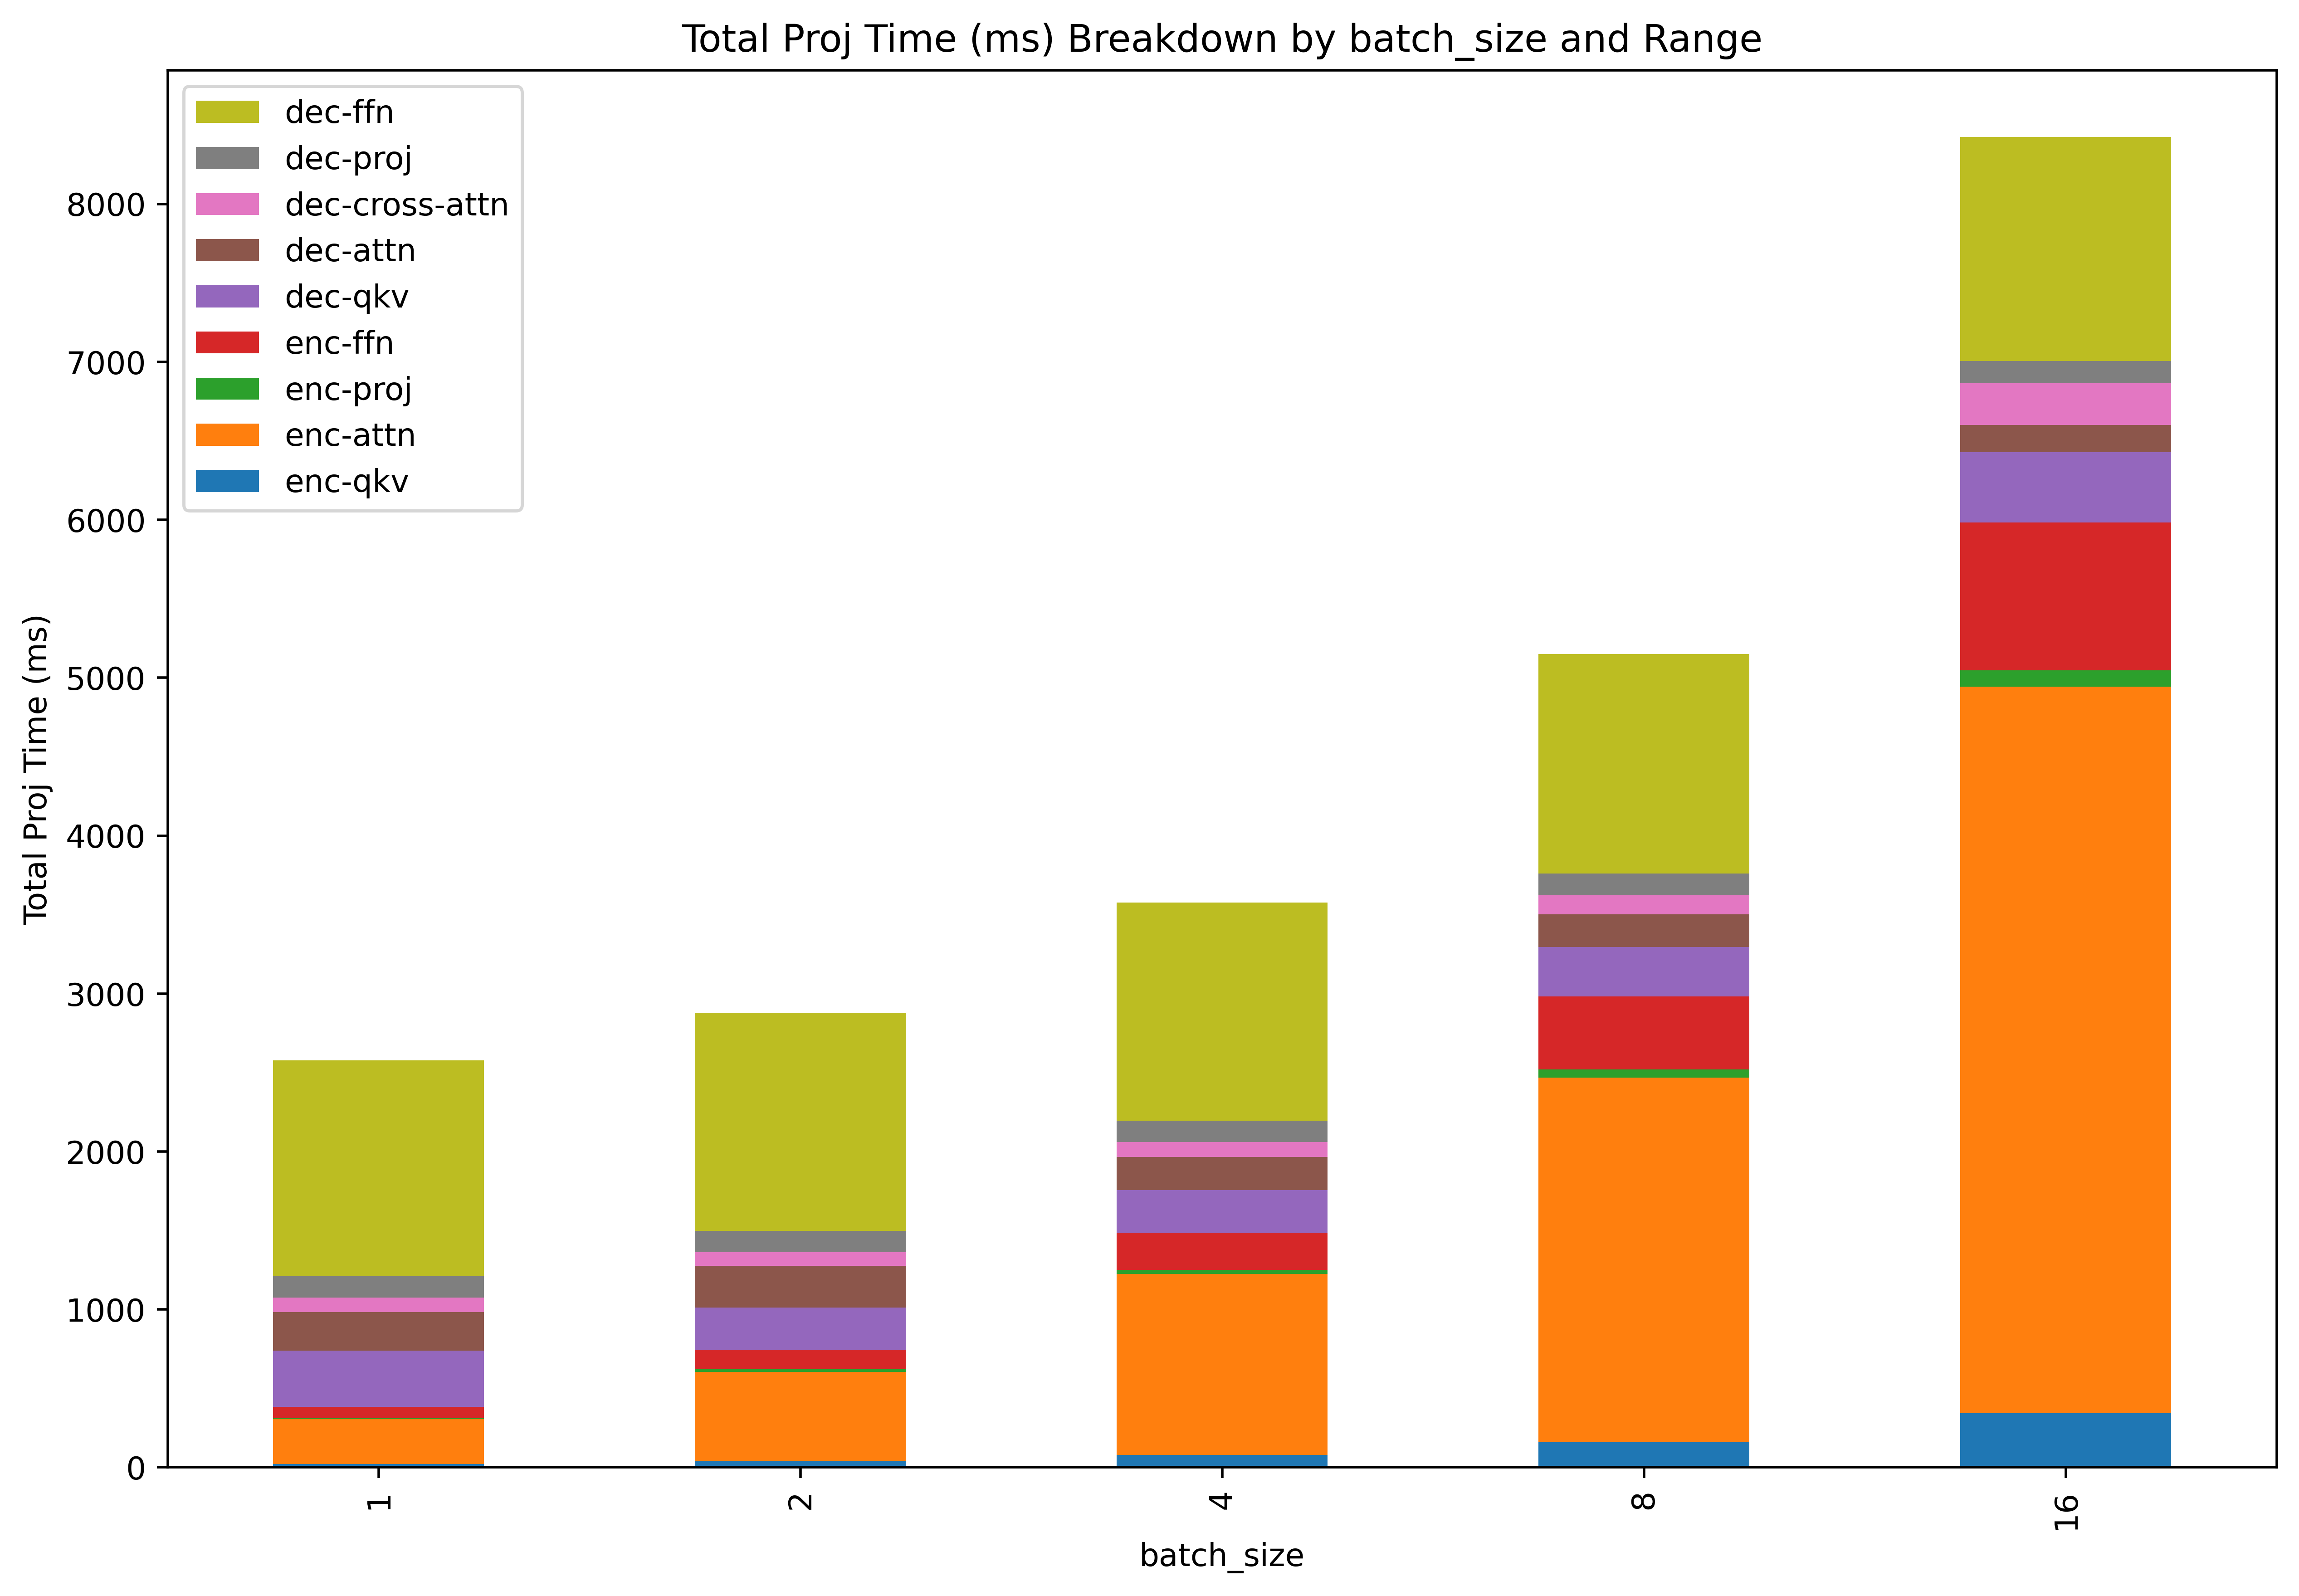

In [142]:
import matplotlib.pyplot as plt


def add_bar_labels(ax, bars, offset, fontsize=10, color="black"):
    """
    막대 그래프에 데이터 레이블을 추가하는 함수

    Parameters:
    - ax: matplotlib axes 객체 (그래프를 그릴 Axes)
    - bars: bar 객체 리스트 (ax.bar()의 반환 값)
    - offset: 막대 위에 레이블을 얼마나 떨어뜨릴지 조정하는 값
    - fontsize: 레이블 폰트 크기
    - color: 레이블 색상
    """
    for bar in bars:
        height = bar.get_height()
        if bar.get_x() + bar.get_width() / 2 == 0.0 and height == 0.0:
            continue
        ax.text(
            bar.get_x() + bar.get_width() / 2,  # 막대의 x 위치 (가운데 정렬)
            height + offset,  # 막대의 y 위치 (조금 위)
            f"{height}",  # 레이블 (소수점 2자리)
            ha="center",  # 가로 중앙 정렬
            fontsize=fontsize,
            color=color,
        )


def plot_stacked_bar(
    df: pd.DataFrame,
    index: str = "batch_size",
    columns: str = "Range",
    values: str = "Total Proj Time (ms)",
    normalize: bool = False,
):
    df_pivot = df.pivot_table(
        index=index, columns=columns, values=values, aggfunc="sum"
    )
    if normalize:
        # axis=0: index
        # axis=1: columns
        # 각 batch_size에 대해 Range별 Total Proj Time (ms)의 합으로 normalize합니다.
        df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    fig, ax = plt.subplots(figsize=(12, 8), dpi=500)
    ax.set_title(f"{values} Breakdown by {index} and {columns}")
    ax.set_xlabel(index)
    ax.set_ylabel(values)
    df_pivot = df_pivot[df[columns].unique()]  # custom order로 정렬
    df_pivot.plot(kind="bar", stacked=True, ax=ax)
    # add_bar_labels(ax, ax.patches, offset=50)
    handles, labels = ax.get_legend_handles_labels()
    order = [labels.index(label) for label in df[columns].unique()]
    # To show legend in the order of stacking, we reverse the order.
    plt.legend(
        [handles[idx] for idx in order[::-1]],
        [labels[idx] for idx in order[::-1]],
        # title=columns,
    )
    plt.show()


# plot_stacked_bar(df_coarse, normalize=False)
# plot_stacked_bar(df_coarse, normalize=True)
plot_stacked_bar(df_fine, normalize=False)
# plot_stacked_bar(df_fine, normalize=True)
# df_coarse